In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import pickle
import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import random
import statsmodels.api as sm 

In [43]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lmm_meixi'

In [29]:
biovar = 'bio17'

In [30]:
pvalues = pd.read_csv(f'results/lmeres_PC1to3_{biovar}_genfirst_gen.csv')

In [31]:
wd = 'results/'

In [32]:
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [33]:
dict_snps = '../key_files/var_pos_grenenet.csv'
dict_snps = pd.read_csv(dict_snps)

## fitler the dict snps since we are only workign with the dfitler maf 
dict_snps_filter = dict_snps.dropna().drop(['total_alleles05filter', 'maf05filter'],axis=1).reset_index(drop=True)

In [34]:
pvalues = pd.concat([dict_snps_filter,pvalues['beta_p']],axis=1)

In [35]:
th = 0.05/len(pvalues)
pvalues['significant'] = pvalues['beta_p'] <= th
pvalues['block'] = pvalues['id'].map(reverse_mapping) #.fillna(df['values'])

In [42]:
pvalues.to_csv(wd + f'results_lmm_{biovar}.csv',index=None)

In [36]:
sign_blocks = pvalues[pvalues['significant']==True].groupby('block')['beta_p'].min().reset_index()

In [37]:
pvalue_blocks = pvalues.groupby('block')['beta_p'].min().reset_index()

In [39]:
sign_blocks.to_csv(wd +  f'sign_blocks_{biovar}_lmm.csv', index=None)
pvalue_blocks.to_csv(wd +  f'pvalue_blocks_{biovar}_lmm.csv', index=None)
print(len(sign_blocks))

0


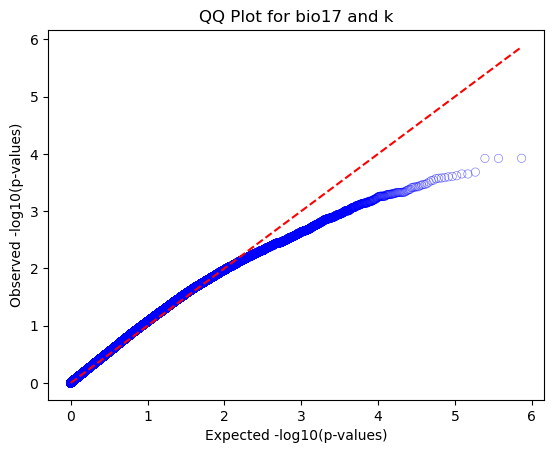

In [15]:
for biovar in ['bio17']:
    pvalues_file = f'lmeres_PC1to3_bio17_genfirst_gen.csv'
    pvalues = pd.read_csv(wd + pvalues_file, usecols = ['beta_p'])
    pvalues.columns = ['pvalue']
    
    # Drop NaNs and ensure p-values are valid
    pvalues = pvalues.dropna()
    pvalues = pvalues[pvalues['pvalue'] > 0]

    # Sort the p-values in ascending order
    observed_quantiles = -np.log10(np.sort(pvalues['pvalue'].values))
    
    # Expected quantiles from the uniform distribution
    expected_quantiles = -np.log10(np.linspace(1 / len(pvalues), 1, len(pvalues)))
    
    # QQ plot
    sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
    plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')
    
    plt.xlabel("Expected -log10(p-values)")
    plt.ylabel("Observed -log10(p-values)")
    plt.title(f'QQ Plot for {biovar} and k')

    plt.show()

In [12]:
wd = 'results/'

/tmp/ipykernel_3070153/1025296536.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


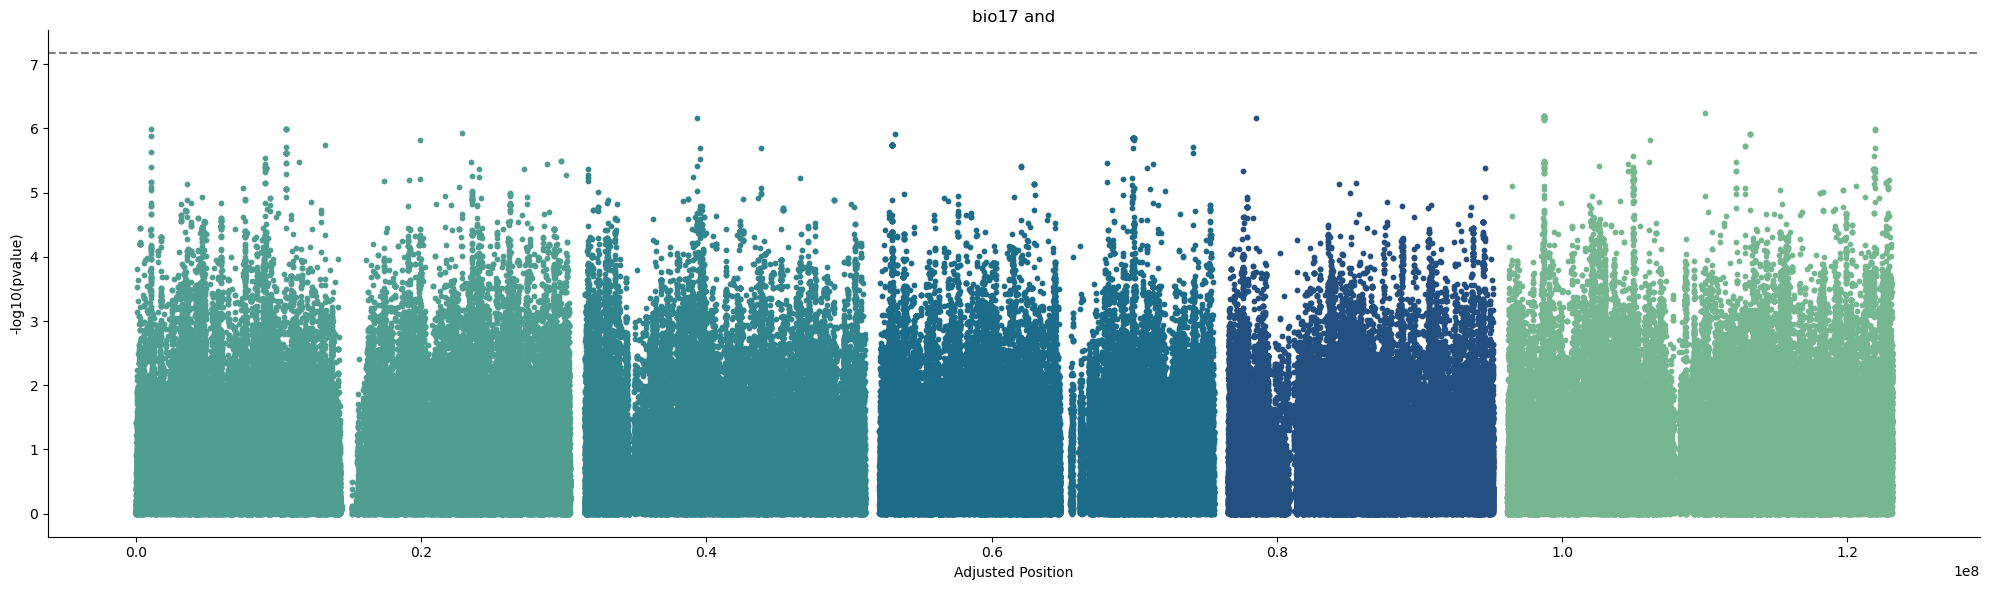

In [14]:
for biovar in ['bio17']:
    #clump= pd.read_csv(f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full/clumping/output/output_clumping_{biovar}.clumped', sep='\s+')
    
        pvalues_file = f'lmeres_PC1to3_bio1_genfirst_gen.csv'
    
        pvalues = dd.read_csv(wd + pvalues_file)
        pvalues = pvalues.compute()#.drop('Unnamed: 0', axis=1)
        
        pvalues = pd.concat([dict_snps_filter,pvalues['beta_p']],axis=1)
        
        pvalues.columns = ['id', 'pos', 'chrom', 'pvalue']
        
        threshold_value = 0.05 / len(pvalues)
        
        #sm.qqplot(pvalues['pvalue'], line ='45') 
        #py.show() 
        
        df = pvalues.copy()
        
        colors = sns.color_palette("crest", n_colors = 5)
        
        # Parsing chromosome number and position
        df['chromosome'] = df['chrom']
        df['position'] = df['pos']
        df['-log10(pvalue)'] = -np.log10(df['pvalue'])
        
        # Calculate the offset for each chromosome to prevent overlap
        chromosome_offsets = {}
        offset = 0
        for chrom in sorted(df['chromosome'].unique()):
            chromosome_offsets[chrom] = offset
            max_position = df[df['chromosome'] == chrom]['position'].max()
            offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes
        
        # Apply offsets to positions
        df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)
        
        # Creating the Manhattan plot
        plt.figure(figsize=(20, 6))
        
        for chrom in sorted(df['chromosome'].unique()):
            subset = df[df['chromosome'] == chrom]
            plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)
        
        
        # Highlight clumped SNPs
        #clumped_subset = df[df['id'].isin(clump['SNP'])]
        #plt.scatter(clumped_subset['adjusted_position'], clumped_subset['-log10(pvalue)'], s=50, facecolors='none', edgecolors='grey', linewidths=2, label='Clumped SNPs')
        
        # Aesthetics
        plt.xlabel('Adjusted Position')
        plt.ylabel('-log10(pvalue)')
        #plt.title('Manhattan Plot')
        #plt.grid(axis='y')
        #plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
        ax = plt.gca()  # Get current axes
        ax.spines['top'].set_visible(False)  # Remove the top spine
        ax.spines['right'].set_visible(False)
        # Threshold line (optional)
        threshold = -np.log10(threshold_value)
        plt.axhline(y=threshold, color='grey', linestyle='dashed')
        plt.title(f'{biovar} and')  # Set the title
    
        # Show the plot
        plt.tight_layout()
        #plt.savefig(wd + f'manhattan_{biovar}.png')
        plt.show()